# K-Means (Cluster Analysis)

In [1]:
import numpy as np
import pandas as pd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp 

from sklearn.preprocessing import scale, MinMaxScaler, Normalizer, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import roc_auc_score,roc_curve, classification_report
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import KMeans
import timeit
from warnings import filterwarnings
filterwarnings('ignore')

/home/asus/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
def correlation_df(data, remove_columns=None):
    if(remove_columns is None):
        corr = data.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    else:
        data2 = data.drop(remove_columns, axis=1)
        corr = data2.corr()
        corr = corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        corr = corr.stack().reset_index()
        new_df = corr[corr["level_0"] != corr["level_1"]]
        new_df.columns = ['feature1','feature2','Corr']
        new_df["Corr"] = abs(new_df["Corr"])
    return new_df

In [3]:
def describe(data):
    desc_df = data.describe().T
    null_count = data.isnull().sum()
    null_percent = (data.isnull().sum() / data.count())*100
    variance = data.var()

    desc_df["variance"] =  round(variance,3)
    desc_df["null_values"] = round(null_count,3)
    desc_df["null__rate"] = round(null_percent,3)
    return desc_df.T

def featureselection_pca(data_minmax, threshold):
    x = data_minmax
    pca = PCA()    
    X_pca = pca.fit_transform(x)
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var])
    return X_pcad

In [4]:
def numeric_categoric_variable(data):
    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    drop_col=[]

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes not in (np.object, np.str)):
            str_var_list.remove(var)
            num_var_list.append(var)
        # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)
    print("Numeric Column  :\n", num_var_list,
          "\n\nCategoric Column :\n", str_var_list)
    return num_var_list, str_var_list

def sortDifferentCategory(data):
    def takeSecond(elem):
        return elem[1]

    listem = []
    for i in data.select_dtypes(include=["object", "int64", "float64"]).columns:
        listem.append([i, data[i].value_counts().count()])

    return sorted(listem, key=takeSecond ,reverse=False)


In [16]:
def layer1(data_norm, remove_col, threshold):
    corr_col=set()
    data2 = data.drop(remove_col, axis=1)
    corrmat=data2.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i,j] > threshold):
                colname=corrmat.columns[i]
                corr_col.add(colname)
    corr_col=list(corr_col)
    layer1_df = data_norm.drop(corr_col, axis=1)
    #layer1_df["labels"] = data_norm["labels"]
    return layer1_df, corr_col

def train_test_splitting(data, target, test_size=0.25, random_state=0, shuffle=False):
    x = data.drop([target], axis=1)
    y = data[target]
    xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)
    return xtrain, xtest, ytrain, ytest

def featureselection_pca(data_minmax, threshold):
    x = data_minmax
    pca = PCA()    
    X_pca = pca.fit_transform(x)
    arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 4)*100)
    num_var = sum((arr < threshold*100)) + 1 
    print('pca sonrası değişken sayısı: ',num_var)
    X_pcad = pd.DataFrame(X_pca[:,0:num_var])
    return X_pcad

def layer2(new_df,num_feats, target):
    x = new_df.drop([target], axis=1)
    y = new_df[target]
    cor_list = []
    feature_name = list(x.columns)
    for i in list(x.columns):
        cor = np.corrcoef(x[i],y)[0,1]
        cor_list.append(cor)

    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    cor_feature = x.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    return cor_feature

def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

def nulldata_check(data, ascending=False):
    count = data.isnull().sum().sort_values(ascending=ascending).to_frame()
    percent = (data.isnull().sum().sort_values(ascending=ascending)/data.iloc[:,-1].count()).to_frame().round(decimals=4)
    df = pd.concat([count, percent], axis=1)
    df.columns = ["count","percentage"]
    return df

def normalization_minmax(dataframe, target):
    x = dataframe
    y = dataframe[target]
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(x)
    array = scaler.transform(x)
    data_minmax = pd.DataFrame(array, columns=dataframe.columns)
    data_minmax[target] = y
    return data_minmax

## **Data Importing**

In [7]:
data = pd.read_excel("HW_Data_Set.xlsx")
data.head()

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_420,ind_422,ind_424,ind_426,ind_428,20_target,50_target,90_target
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,-152,-353,1.0,0.498547,0.701906,15.135802,35.625252,36.997753
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,-158,-359,1.0,0.537088,0.690833,15.143348,35.643013,37.016198
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,-160,-362,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,-61.8,-65,-166,-367,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,-79.8,-86,-186,-388,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503


# **1. Data EXploration**

### 1.1. Data Statistics

In [8]:
data.shape

(6167, 136)

In [9]:
describe(data)

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_412,ind_414,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target
count,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,...,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000,6167.000000
mean,-0.803146,-0.803470,48.388890,48.289282,0.099609,49.488867,-18.497518,11.771485,11.773550,11.773392,...,0.000224,28.529204,-8.554792,-28.166694,0.490297,0.498188,0.490174,-0.057102,-2.906358,-3.315072
std,23.624403,23.624144,36.388526,36.478009,60.414625,12.198722,68.281120,6.803997,5.786089,4.970499,...,0.005660,26.316896,16.100087,23.271524,0.425376,0.228547,0.150483,14.834497,34.559778,36.841541
min,-131.000000,-131.000000,0.000000,0.000000,-100.000000,12.134540,-625.093855,1.050000,1.660000,2.580000,...,-0.023790,0.000000,-103.800000,-188.000000,0.000000,0.000000,0.083530,-15.780588,-37.142889,-38.573858
25%,-14.000000,-14.000000,14.285714,14.285714,-50.000000,40.868503,-45.687212,6.850000,7.260000,7.635000,...,-0.003230,10.700000,-11.700000,-39.000000,0.000000,0.323783,0.379894,-15.350354,-36.208094,-37.695273
50%,0.000000,0.000000,50.000000,50.000000,0.000000,49.549766,-2.817298,10.550000,11.040000,11.270000,...,-0.000053,21.300000,0.000000,-22.000000,0.473684,0.495192,0.487078,0.000000,-34.267756,-35.788391
75%,13.000000,13.000000,85.714286,85.714286,57.142857,58.504375,28.072613,14.950000,15.040000,14.960000,...,0.003414,38.400000,0.000000,-11.000000,1.000000,0.675730,0.601508,15.385945,35.879524,37.521892
max,76.000000,76.000000,100.000000,100.000000,100.000000,84.821848,81.105847,82.900000,54.240000,37.050000,...,0.023340,281.800000,0.000000,0.000000,1.000000,1.000000,0.868534,15.768767,37.038694,38.465649
variance,558.112000,558.100000,1324.125000,1330.645000,3649.927000,148.809000,4662.311000,46.294000,33.479000,24.706000,...,0.000000,692.579000,259.213000,541.564000,0.181000,0.052000,0.023000,220.062000,1194.378000,1357.299000
null_values,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### **1.2. Categoric and Numeric variables Analysis**

In [10]:
num, cat = numeric_categoric_variable(data)

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

In [11]:
sortDifferentCategory(data)

[['ind_109', 2],
 ['ind_40', 6],
 ['ind_82', 6],
 ['ind_217', 6],
 ['ind_28', 7],
 ['ind_349', 7],
 ['ind_8', 15],
 ['ind_9', 15],
 ['ind_351', 17],
 ['ind_352', 17],
 ['ind_70', 18],
 ['ind_67', 22],
 ['ind_344', 22],
 ['ind_83', 25],
 ['ind_10', 29],
 ['ind_77', 37],
 ['ind_61', 38],
 ['ind_74', 42],
 ['ind_71', 46],
 ['ind_58', 50],
 ['ind_122', 52],
 ['ind_65', 55],
 ['ind_62', 64],
 ['ind_347', 69],
 ['ind_42', 71],
 ['ind_334', 71],
 ['ind_19', 83],
 ['ind_21', 84],
 ['ind_52', 90],
 ['ind_136', 91],
 ['ind_134', 93],
 ['ind_43', 94],
 ['ind_56', 102],
 ['ind_407', 103],
 ['ind_345', 108],
 ['ind_44', 109],
 ['ind_45', 126],
 ['ind_124', 128],
 ['ind_53', 131],
 ['ind_116', 131],
 ['ind_46', 135],
 ['ind_418', 139],
 ['ind_20', 141],
 ['ind_410', 143],
 ['ind_234', 157],
 ['ind_47', 159],
 ['ind_5', 162],
 ['ind_6', 162],
 ['ind_48', 175],
 ['ind_23', 177],
 ['ind_49', 189],
 ['ind_22', 192],
 ['ind_406', 200],
 ['ind_128', 201],
 ['ind_324', 241],
 ['ind_309', 249],
 ['ind_50', 

### **1.3. NULL Value Checking**

In [12]:
nulldata_check(data).sort_values(by="count",ascending=False).head(7)

,count,percentage
90_target,0,0.0
ind_416,0,0.0
ind_404,0,0.0
ind_406,0,0.0
ind_407,0,0.0
ind_410,0,0.0
ind_412,0,0.0


# Data Preprocessing

### **2.1. Noise data cleaning**

In [13]:
#data["ind_420"] = data["ind_420"].replace("?", np.nan)
#data["ind_422"] = data["ind_422"].replace("?", np.nan)
data = data.drop(["ind_420", "ind_422"],axis=1)

### **2.2. Dummy Transformation**

In [18]:
data_dummy = dummy_df(data, ["ind_109"])
data_dummy2 = dummy_df(data, ["ind_109","ind_40"])

num, cat = numeric_categoric_variable(data_dummy)
data_dummy.head()

Numeric Column  :
 ['ind_5', 'ind_6', 'ind_8', 'ind_9', 'ind_10', 'ind_12', 'ind_13', 'ind_14', 'ind_15', 'ind_16', 'ind_17', 'ind_18', 'ind_19', 'ind_20', 'ind_21', 'ind_22', 'ind_23', 'ind_25', 'ind_26', 'ind_27', 'ind_28', 'ind_29', 'ind_30', 'ind_31', 'ind_32', 'ind_33', 'ind_34', 'ind_35', 'ind_36', 'ind_37', 'ind_39', 'ind_40', 'ind_41', 'ind_42', 'ind_43', 'ind_44', 'ind_45', 'ind_46', 'ind_47', 'ind_48', 'ind_49', 'ind_50', 'ind_51', 'ind_52', 'ind_53', 'ind_56', 'ind_58', 'ind_61', 'ind_62', 'ind_65', 'ind_67', 'ind_70', 'ind_71', 'ind_74', 'ind_77', 'ind_82', 'ind_83', 'ind_88', 'ind_92', 'ind_102', 'ind_116', 'ind_118', 'ind_122', 'ind_124', 'ind_128', 'ind_130', 'ind_132', 'ind_134', 'ind_136', 'ind_139', 'ind_142', 'ind_145', 'ind_147', 'ind_150', 'ind_153', 'ind_156', 'ind_164', 'ind_168', 'ind_172', 'ind_176', 'ind_179', 'ind_181', 'ind_188', 'ind_194', 'ind_212', 'ind_217', 'ind_225', 'ind_228', 'ind_234', 'ind_237', 'ind_239', 'ind_241', 'ind_243', 'ind_309', 'ind_310'

,ind_5,ind_6,ind_8,ind_9,ind_10,ind_12,ind_13,ind_14,ind_15,ind_16,...,ind_416,ind_418,ind_424,ind_426,ind_428,20_target,50_target,90_target,ind_109_GREEN,ind_109_RED
0,19,17,100.0,85.714286,14.285714,72.363515,60.808814,23.80,17.62,11.73,...,-49.6,-54,1.0,0.498547,0.701906,15.135802,35.625252,36.997753,1,0
1,24,19,100.0,78.571429,21.428571,74.275883,64.366798,11.45,18.16,12.22,...,-55.6,-60,1.0,0.537088,0.690833,15.143348,35.643013,37.016198,1,0
2,30,24,100.0,71.428571,28.571429,75.140402,65.915803,8.75,17.86,12.28,...,-58.4,-60,1.0,0.615169,0.693040,15.146870,35.651301,-37.024805,1,0
3,37,30,100.0,64.285714,35.714286,76.677846,68.584234,7.80,14.76,12.61,...,-61.8,-65,1.0,0.661517,0.673418,15.153283,0.000000,-37.040483,1,0
4,41,37,100.0,57.142857,42.857143,81.603007,76.455495,14.90,11.92,14.25,...,-79.8,-86,1.0,0.747204,0.700522,-15.179065,-35.727079,-37.103503,1,0


### **2.3. Target variables are dropped**

In [19]:
data_dummy = data_dummy.drop(["20_target","50_target","90_target"], axis=1)

# **3. PCA based Feature Selection**

In [20]:
data_pca = featureselection_pca(scale(data_dummy), 0.9)
data_pca.head()

pca sonrası değişken sayısı:  27


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,-11.822543,-3.268841,6.502793,-1.394212,0.665758,-0.908406,-1.772313,-0.752222,-1.523123,-2.455193,...,1.060794,3.049259,3.753820,-2.460912,-1.123208,-0.942609,1.431210,-0.205931,0.588325,0.251256
1,-12.884857,-2.833142,5.023846,-0.594320,1.613146,-1.373742,-1.743751,-0.854689,-0.841788,-2.731657,...,1.318130,3.216427,3.705629,-2.555429,-1.185169,-1.110279,1.504580,-0.121952,0.440620,-0.215571
2,-12.949664,-1.238067,3.565824,0.309928,1.971284,-1.345161,-0.958778,-1.099323,0.018290,-2.482215,...,1.051653,2.568360,4.054702,-1.876180,-0.936944,-1.457186,1.854109,-0.294099,0.383503,-0.507689
3,-13.350084,-0.231834,2.624446,0.497977,1.572311,-0.245229,1.285996,-1.477630,1.030668,-2.091441,...,0.915179,1.934965,4.379649,-1.398998,-0.853110,-1.837458,2.081547,-0.438559,0.413122,-0.649488
4,-17.193741,-3.264592,4.634170,0.257018,-0.164442,1.173461,2.506775,-1.415957,0.870062,-3.712507,...,0.411976,2.112795,5.206533,-0.225840,-0.091029,-2.383541,1.983209,-0.902630,-0.675597,-1.392129


# **4. Modelling K-Means**

In [22]:
kmeans = KMeans(n_clusters=4)
k_fit = kmeans.fit(data_pca)
k_fit.n_clusters

4

In [23]:
kmeans = KMeans(n_clusters=5)
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### 4.2. Cluster Centers

In [24]:
kumeler = k_fit.labels_
k_fit.cluster_centers_

array([[-2.30902740e+00,  3.41405003e+00, -3.35225563e-01,
        -1.00962639e+00, -1.40337022e-01, -2.19913749e-01,
        -2.83522969e-01, -1.19424599e-01,  1.86916493e-02,
         2.63366315e-01,  2.56132583e-01, -1.78001135e-01,
         2.89532719e-01, -3.95008555e-02,  2.11569904e-01,
         4.50606282e-01, -7.79958018e-02, -6.08407931e-02,
        -5.65965061e-02,  4.97966500e-03, -9.96359573e-02,
         7.87504558e-03, -3.63070860e-02, -2.03796854e-01,
         7.19504048e-02, -8.12660067e-02,  2.37930554e-01],
       [ 1.47545120e+00, -3.12618419e+00, -7.40452660e-01,
        -3.54162336e-01,  5.25954204e-01,  1.00129234e-01,
         2.84889773e-01, -3.24775991e-02, -1.14628504e-01,
        -1.60340575e-01,  1.42470098e-01, -8.40986720e-02,
        -1.11492405e-01, -2.80224931e-02, -8.41199890e-02,
        -4.60002425e-01,  5.84376002e-02,  2.37459243e-02,
        -2.28940821e-02, -6.35587836e-02,  7.68312209e-02,
        -1.31645798e-01,  6.34249182e-02,  5.20395660e-

In [25]:
k_fit.labels_

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

### 4.2. Visualization Cluster Centers

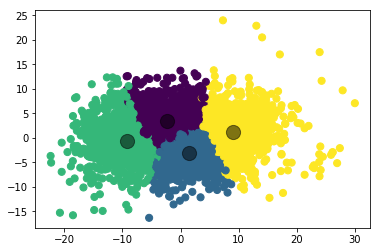

In [26]:
plt.scatter(data_pca.iloc[:,0], data_pca.iloc[:,1], c=kumeler, s=50, cmap="viridis")
merkezler = k_fit.cluster_centers_
plt.scatter(merkezler[:,0], merkezler[:,1], c="black", s=200, alpha=0.5)
plt.show()

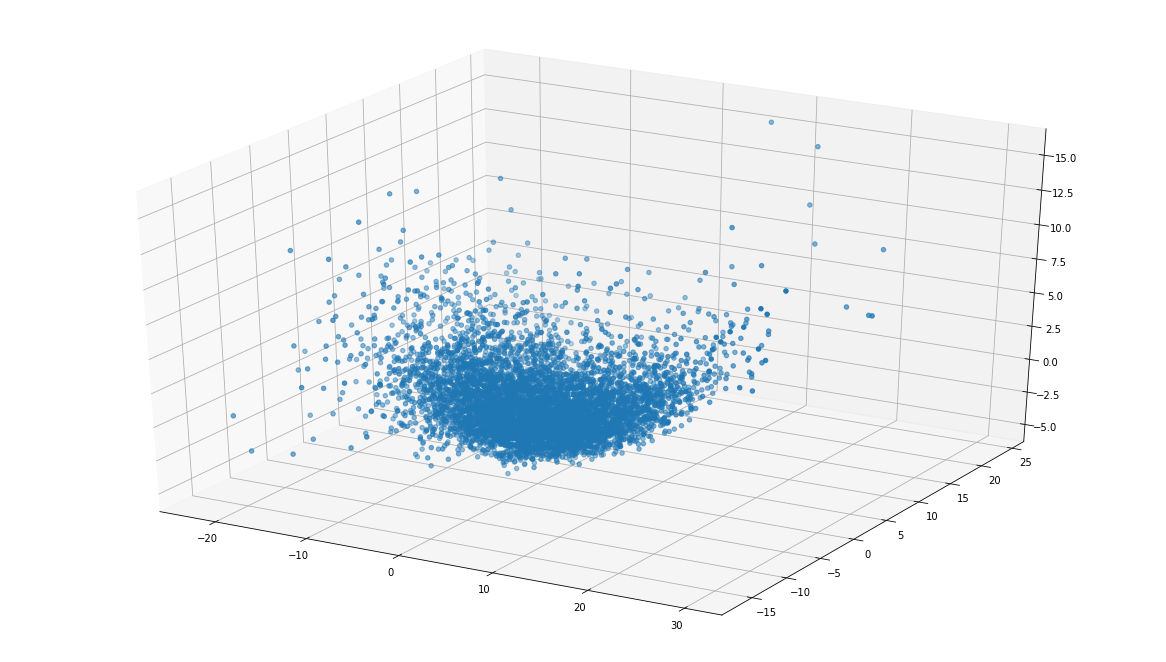

In [27]:
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.figsize'] = (16, 9)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data_pca.iloc[:, 0], data_pca.iloc[:, 1], data_pca.iloc[:, 3]);

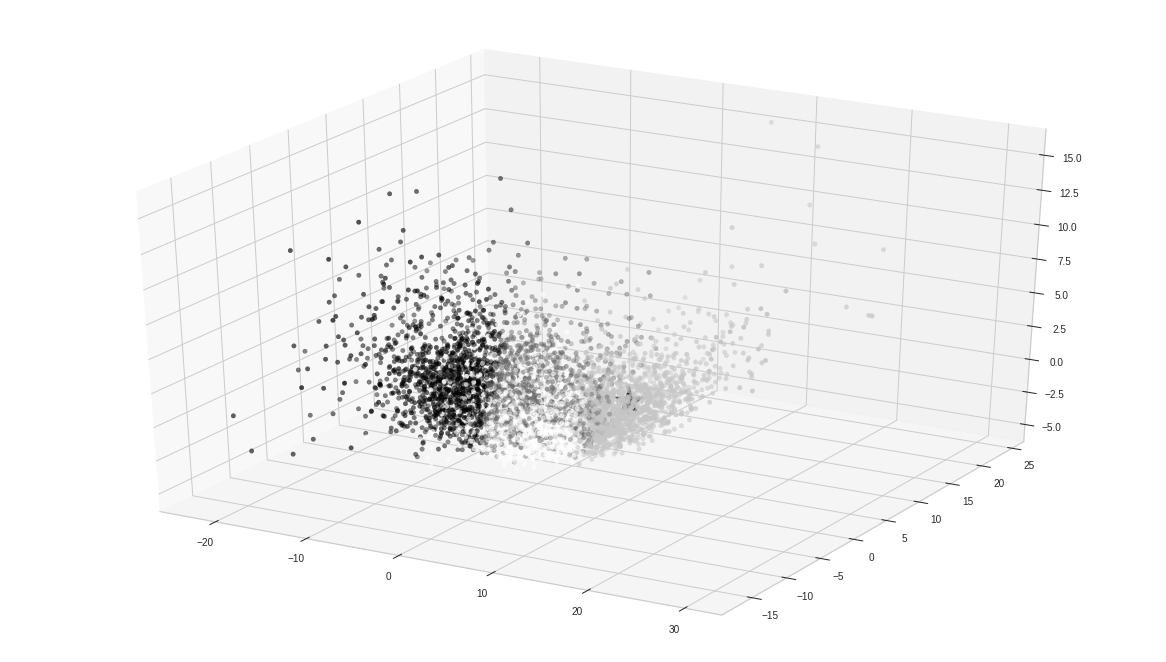

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data_pca.iloc[:, 0], data_pca.iloc[:, 1], data_pca.iloc[:, 3], c=kumeler)
ax.scatter(merkezler[:, 0], merkezler[:, 1], merkezler[:, 3], 
           marker='*', 
           c='#080808', 
           s=1000);

In [28]:
data_kmeans = data_pca
data_kmeans["clusters"] = kumeler
data_kmeans.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,clusters
0,-11.822543,-3.268841,6.502793,-1.394212,0.665758,-0.908406,-1.772313,-0.752222,-1.523123,-2.455193,...,3.049259,3.753820,-2.460912,-1.123208,-0.942609,1.431210,-0.205931,0.588325,0.251256,2
1,-12.884857,-2.833142,5.023846,-0.594320,1.613146,-1.373742,-1.743751,-0.854689,-0.841788,-2.731657,...,3.216427,3.705629,-2.555429,-1.185169,-1.110279,1.504580,-0.121952,0.440620,-0.215571,2
2,-12.949664,-1.238067,3.565824,0.309928,1.971284,-1.345161,-0.958778,-1.099323,0.018290,-2.482215,...,2.568360,4.054702,-1.876180,-0.936944,-1.457186,1.854109,-0.294099,0.383503,-0.507689,2
3,-13.350084,-0.231834,2.624446,0.497977,1.572311,-0.245229,1.285996,-1.477630,1.030668,-2.091441,...,1.934965,4.379649,-1.398998,-0.853110,-1.837458,2.081547,-0.438559,0.413122,-0.649488,2
4,-17.193741,-3.264592,4.634170,0.257018,-0.164442,1.173461,2.506775,-1.415957,0.870062,-3.712507,...,2.112795,5.206533,-0.225840,-0.091029,-2.383541,1.983209,-0.902630,-0.675597,-1.392129,2


In [29]:
data_kmeans.groupby("clusters").count()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
clusters,,,,,,,,,,,,,,,,,,,,,
0,1495,1495,1495,1495,1495,1495,1495,1495,1495,1495,...,1495,1495,1495,1495,1495,1495,1495,1495,1495,1495
1,1939,1939,1939,1939,1939,1939,1939,1939,1939,1939,...,1939,1939,1939,1939,1939,1939,1939,1939,1939,1939
2,1321,1321,1321,1321,1321,1321,1321,1321,1321,1321,...,1321,1321,1321,1321,1321,1321,1321,1321,1321,1321
3,1412,1412,1412,1412,1412,1412,1412,1412,1412,1412,...,1412,1412,1412,1412,1412,1412,1412,1412,1412,1412


### 4.3. Optimum Cluster using Silhouette Score

In [30]:
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_labels = k_fit.fit_predict(data_pca)
silhouette_avg = silhouette_score(data_pca, cluster_labels)
print("Silhouette: ",silhouette_avg)

Silhouette:  0.1446959453026557


### 4.4. **Optimum Cluster using KElbowVisualizer**

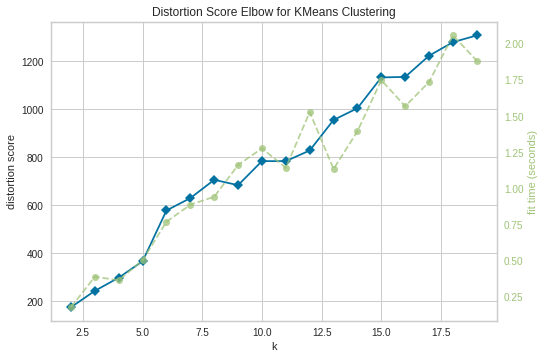

In [ ]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,20))
visualizer.fit(data_pca)
visualizer.poof()

# **5. Model Tuning**

In [ ]:
def KMeansTuning(data_pca, params, cv=10, n_jobs=-1, verbose=2):
    model = KMeans()
    gridsearch_cv = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, verbose=verbose)
    grid_cv_model = gridsearch_cv.fit(data_pca)
    # best parameters
    model.n_clusters = grid_cv_model.best_params_["n_clusters"]
    model.init = grid_cv_model.best_params_["init"]
    model.max_iter = grid_cv_model.best_params_["max_iter"]
    # tuned model
    model_tuned = model.fit(data_pca)
    labels = model_tuned.labels_
    centroids = model_tuned.cluster_centers_
    return labels,centroids, model, grid_cv_model.best_params_

In [ ]:
kmeans_params = {"n_clusters": np.arange(2,20),
              "init": ["k-means++", "random"],
              "max_iter": [300,500]}

labels, centroids, kmeans_model, best_params = KMeansTuning(data_pca, kmeans_params)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  7.3min finished


In [ ]:
kmeans_model.fit(data_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=19, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
kmeans_model.labels_

array([ 1,  1,  1, ..., 12, 12, 12], dtype=int32)

### 5.1. Visualization Cluster Centers

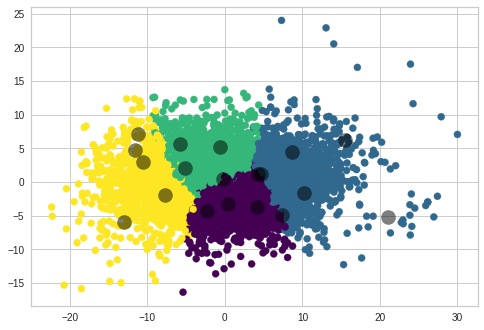

In [ ]:
plt.scatter(data_pca.iloc[:,0], data_pca.iloc[:,1], c=kumeler, s=50, cmap="viridis")
merkezler = kmeans_model.cluster_centers_
plt.scatter(merkezler[:,0], merkezler[:,1], c="black", s=200, alpha=0.5)
plt.show()

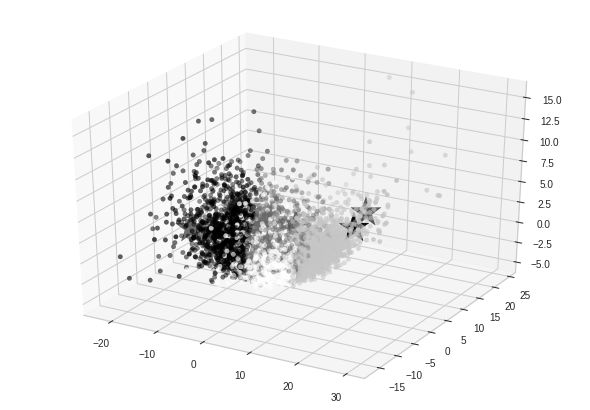

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data_pca.iloc[:, 0], data_pca.iloc[:, 1], data_pca.iloc[:, 3], c=kumeler)
ax.scatter(merkezler[:, 0], merkezler[:, 1], merkezler[:, 3], 
           marker='*', 
           c='#080808', 
           s=1000);

### 5.2. Optimum Cluster using Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_labels2 = kmeans_model.fit_predict(data_pca)
silhouette_avg = silhouette_score(data_pca, cluster_labels2)
print("Silhouette: ",silhouette_avg)

Silhouette:  0.10404715816456168
